# Audio reconstruction with context encoder

*   Original data and corrupted data (waveforms)
*   Original data and corrupted data (melspectrogram)

*   Original data, corrupted data, missing part (melspectrogram), reconstructed part (melspectrogram)
*   corrupted data (melspectrogram) + reconstructed part (melspectrogram) -> waveform (mel_to_audio)

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import pandas as pd
import random 
import copy
from numpy import savez_compressed, load
import keras.backend as K
from keras import regularizers
from keras.layers import Lambda
from keras.layers.convolutional import Conv2D, MaxPooling2D, UpSampling2D
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.core import Activation, Dense
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import gc
import IPython.display as ipd 

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Loading data

In [4]:
# load dict of arrays
dict_data = load("/content/gdrive/MyDrive/UrbanSound8K/dati/dataset8kHz.npz")
# extract the first array
data = dict_data['arr_0']
# label for each file, corresponding to the class
labels = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/dati/all_labels.csv")
labels = labels['0']
metadata = pd.read_csv("/content/gdrive/MyDrive/UrbanSound8K/metadata/UrbanSound8K.csv")
classes=np.unique(metadata["class"])
mapping=classes.tolist() 

In [5]:
data = data.reshape(-1,32000,1)

Prova normalizzazione RMS:
L'RMS della maggior parte dei file audio è =1, perciò dividere l'intero segnale audio per l'RMS non lo fa cambiare

In [ ]:
data[113]

array([[-0.27161938],
       [ 0.1105403 ],
       [-0.04591512],
       ...,
       [ 0.30336031],
       [ 0.07465872],
       [ 0.12048929]])

In [ ]:
for i in data[100:130]:
  print(np.sqrt(np.mean(i**2)))

1.0000000109807097
0.999999964738467
1.000000086008417
0.9999999272195547
0.9999999355130378
1.0000000000596332
1.000000050784362
0.9999999802539691
1.000000042841235
0.9999999211318797
0.9999999474176824
1.000000021046108
0.36038174046859484
0.9999999962066344
0.999999929591731
0.9999999960752209
1.0000000047680249
1.0000000675231187
1.0000000145824222
0.9999999705149836
0.9999999862623271
0.8868483704706955
1.0000000243845173
0.9999999832418385
1.000000013383123
1.0000000102856705
0.9999999979007171
0.9999999956676087
1.0000000171729573
1.0000000160303626


Prove

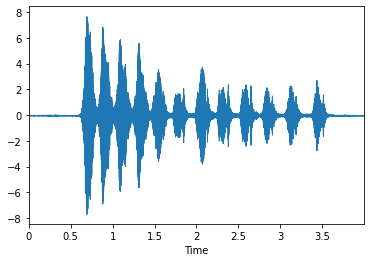

In [ ]:
librosa.display.waveplot(data[1].reshape(-1), sr=8000)

In [6]:
import matplotlib.pyplot as plt

def plot_spectrogram(X):
  sr=8000
  fig, ax = plt.subplots()
  S_dB = librosa.power_to_db(X, ref=np.max)
  img = librosa.display.specshow(S_dB, x_axis='time',
                          y_axis='mel', sr=sr,
                          fmax=8000, ax=ax)
  fig.colorbar(img, ax=ax, format='%+2.0f dB')
  ax.set(title='Mel-frequency spectrogram')

In [ ]:
x = data[6, :]
x_corr = copy.deepcopy(x)
x_corr[0:2000]=0
x_missing = data[6, 0:2000]

In [ ]:
print("Waveform shape: ", x.shape)
print("Corruption shape: ", x_missing.shape)
print("Waveform shape after reshape(-1): ", x.reshape(-1).shape)
print("Corruption shape after reshape(-1): ", x_missing.reshape(-1).shape)

Waveform shape:  (32000, 1)
Corruption shape:  (2000, 1)
Waveform shape after reshape(-1):  (32000,)
Corruption shape after reshape(-1):  (2000,)


In [ ]:
x_mel = librosa.feature.melspectrogram(y=x.reshape(-1), sr=8000)
x_corr_mel = librosa.feature.melspectrogram(y=x_corr.reshape(-1), sr=8000)
x_missing_mel = librosa.feature.melspectrogram(y=x_missing.reshape(-1), sr=8000)
x_recon = copy.deepcopy(x_corr_mel)
x_recon[:, 0:4]=x_missing_mel

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=2000
  n_fft, y.shape[-1]


In [ ]:
x_norm = (x - np.min(x)) / (np.max(x)-np.min(x))

Tentativo di ricostruzione (random) con hop_length = 500 

In [ ]:
x_mel_norm = librosa.feature.melspectrogram(y=x_norm.reshape(-1), sr=8000, hop_length=501)

In [ ]:
print(x_mel_norm.shape)

(128, 64)


In [ ]:
x_mel_norm[:,5:21]=0

In [ ]:
tmp = np.random.rand(128,16)

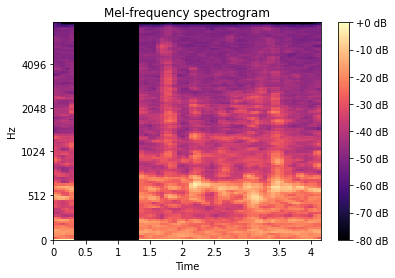

In [ ]:
plot_spectrogram(x_mel_norm)

In [ ]:
x_mel_norm[:,5:21]=tmp

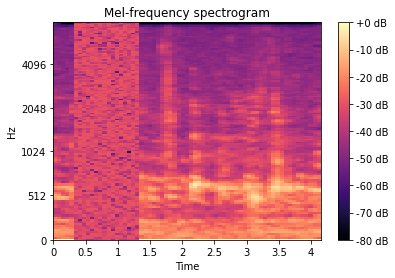

In [ ]:
plot_spectrogram(x_mel_norm)

In [ ]:
mel_to_wave = librosa.feature.inverse.mel_to_audio(x_mel_norm, sr=8000, hop_length=500)

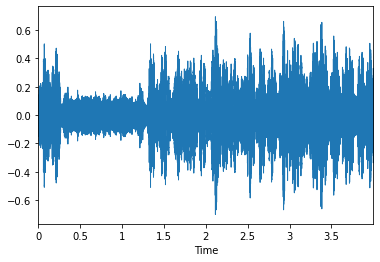

In [ ]:
librosa.display.waveplot(mel_to_wave.reshape(-1), sr=8000)

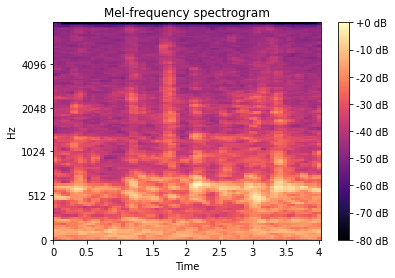

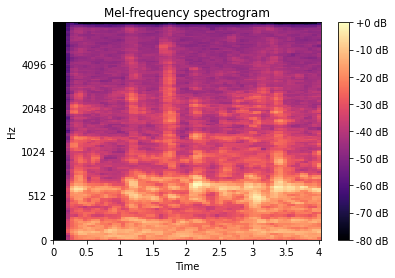

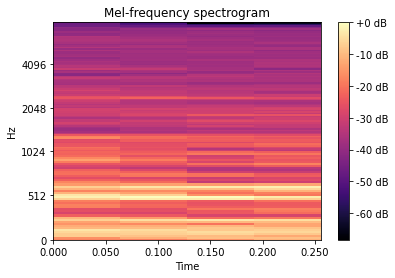

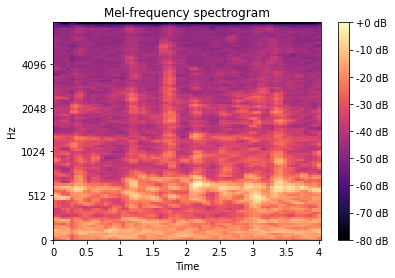

In [ ]:
plot_spectrogram(x_mel) # mel spectrogram 
plot_spectrogram(x_corr_mel) # mel spectrogram corrotto 
plot_spectrogram(x_missing_mel) # missing part 
plot_spectrogram(x_recon) # reconstructed mel spectrogram 

In [ ]:
prova = (x_mel - np.min(x_mel)) / (np.max(x_mel)-np.min(x_mel))

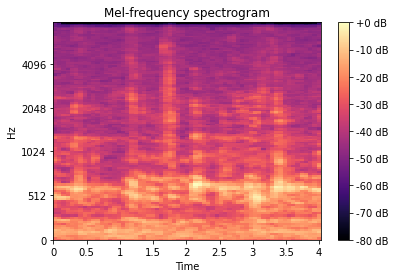

In [ ]:
plot_spectrogram(prova)

In [ ]:
mel_to_wave = librosa.feature.inverse.mel_to_audio(prova, sr=8000)

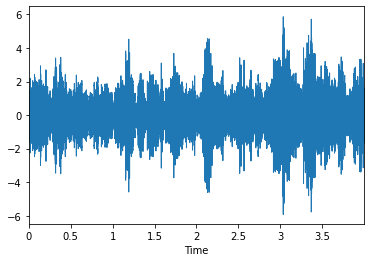

In [ ]:
librosa.display.waveplot(data[6].reshape(-1), sr=8000)

In [ ]:
mel_to_wave = (mel_to_wave * (np.max(x_mel)-np.min(x_mel)) ) +  np.min(x_mel)

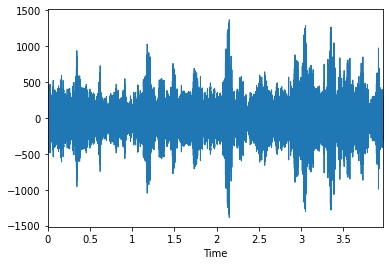

In [ ]:
librosa.display.waveplot(mel_to_wave.reshape(-1), sr=8000)

In [ ]:
print("Melspectrogram shape: ", x_mel.shape)
print("Corrupted melspectrogram shape: ", x_corr_mel.shape)
print("Corruption shape (melspectrogram): ", x_missing_mel.shape) # (128,1) se la corruzione è di 500; (128, 16) se la corruzione è di 8000
print("Reconstructed melspectrogram shape: ", x_recon.shape)

Melspectrogram shape:  (128, 63)
Corrupted melspectrogram shape:  (128, 63)
Corruption shape (melspectrogram):  (128, 4)
Reconstructed melspectrogram shape:  (128, 63)


In [ ]:
inverse_missing_part = librosa.feature.inverse.mel_to_audio(x_missing_mel, sr=8000)

/usr/local/lib/python3.7/dist-packages/librosa/core/spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1536
  n_fft, y.shape[-1]


In [ ]:
inverse_missing_part.shape

(1536,)

In [ ]:
inverse = librosa.feature.inverse.mel_to_audio(x_recon, sr=8000) 

In [ ]:
inverse.shape

(31744,)

**Waveform originale**

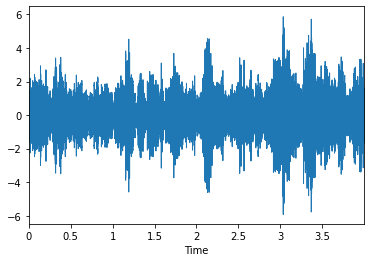

In [ ]:
librosa.display.waveplot(x.reshape(-1), sr=8000)

**Waveform corrotta**

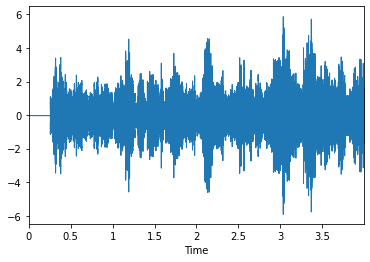

In [ ]:
librosa.display.waveplot(x_corr.reshape(-1), sr=8000)

**Waveform ricostruita**

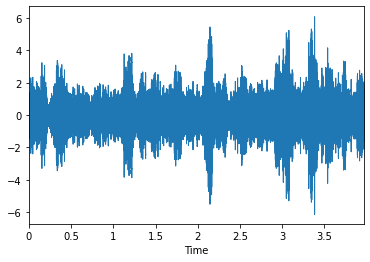

In [ ]:
librosa.display.waveplot(inverse.reshape(-1), sr=8000)

In [ ]:
import numpy as np 

In [ ]:
test = np.random.rand(10,128,63)

In [ ]:
print(np.max(test, axis=0).shape) #matrice dei massimi: max per ogni punto 
print(np.max(test, axis=1).shape)
print(np.max(test, axis=(1,2)).shape) #axis = (1,2) sono le due dim dell'immagini (la posizione 0 è il batch size)
print(np.max(test, axis=2).shape)

(128, 63)
(10, 63)
(10,)
(10, 128)


In [ ]:
max_vec = np.max(test, axis=(1,2)).reshape(-1,1)
min_vec = np.min(test, axis=(1,2)).reshape(-1,1)

In [ ]:
zipped_vec = zip(test,max_vec,min_vec)
normalized_list = [(x-min_x)/(max_x-min_x) for x,max_x,min_x in zipped_vec]
normalized_list = np.array(normalized_list)

In [ ]:
normalized_list.shape

(10, 128, 63)

# GAN Context Encoder
The network structure is inspired by https://github.com/eriklindernoren/Keras-GAN/blob/master/context_encoder/context_encoder.py

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 8, 64)         640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 8, 64)         0         
                                                                 
 batch_normalization (BatchN  (None, 64, 8, 64)        256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 4, 128)        73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 4, 128)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 32, 4, 128)       512       
 hNormalization)                                        

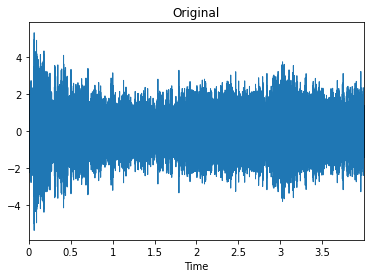

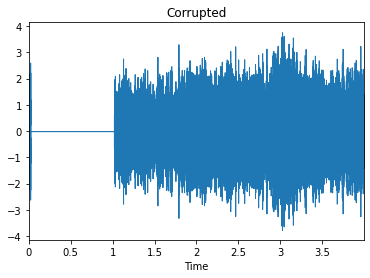

x1mel shape: [ 0 45  2 35  7 16]
x2mel shape: [16 61 18 51 23 32]


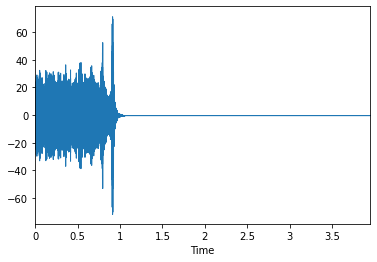

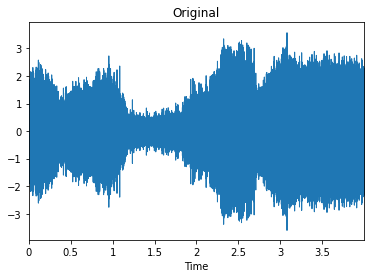

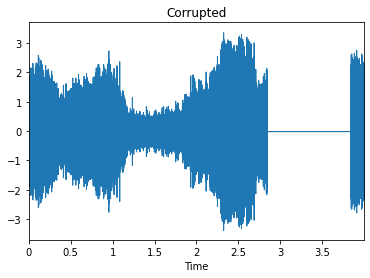

x1mel shape: [ 0 45  2 35  7 16]
x2mel shape: [16 61 18 51 23 32]


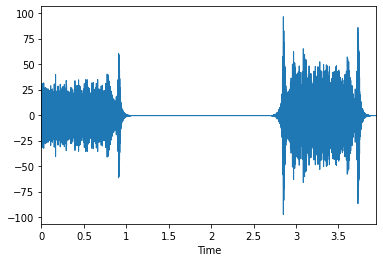

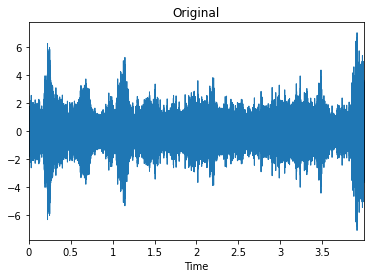

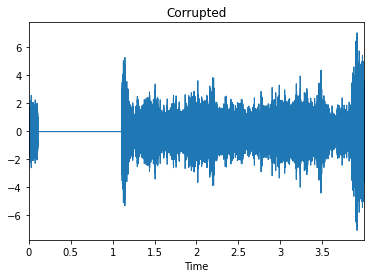

x1mel shape: [ 0 45  2 35  7 16]
x2mel shape: [16 61 18 51 23 32]


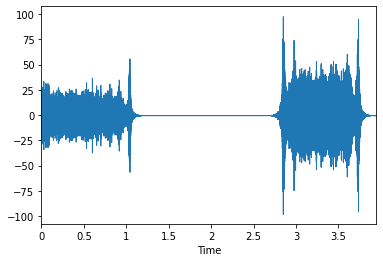

Masked Imgs Mel Shape after min max norm: (64, 128, 64)
1 [D loss: 0.424239, acc: 49.22%] [G loss: 0.950613, mse: 0.950916]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
2 [D loss: 0.447243, acc: 50.00%] [G loss: 0.989253, mse: 0.989619]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
3 [D loss: 0.591670, acc: 98.44%] [G loss: 59.929749, mse: 59.989124]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
4 [D loss: 0.045347, acc: 100.00%] [G loss: 0.952528, mse: 0.952923]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
5 [D loss: 0.046819, acc: 100.00%] [G loss: 0.950376, mse: 0.950844]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
6 [D loss: 0.041508, acc: 100.00%] [G loss: 0.933416, mse: 0.933948]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
7 [D loss: 0.045895, acc: 100.00%] [G loss: 0.937000, mse: 0.937612]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
8 [D loss: 0.090615, acc: 99.22%] [G loss: 1.709035, mse: 1.710566]
Ma

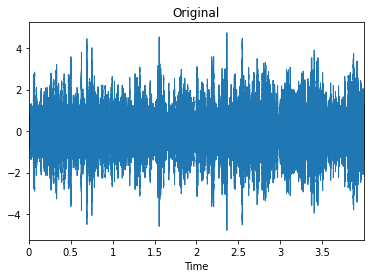

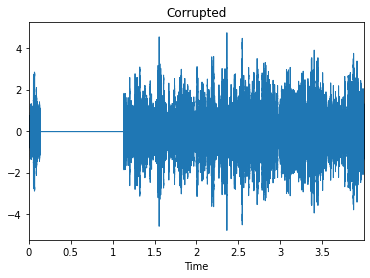

x1mel shape: [ 2 26 36 34 27 27]
x2mel shape: [18 42 52 50 43 43]


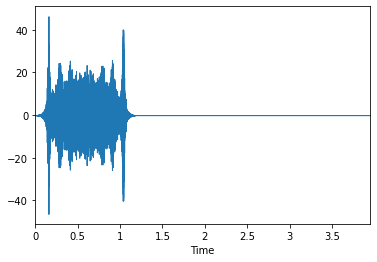

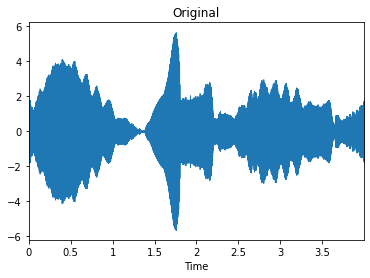

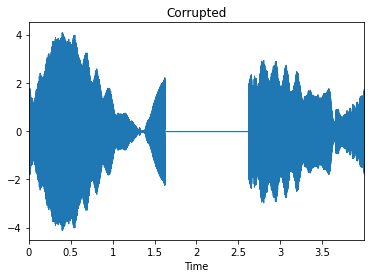

x1mel shape: [ 2 26 36 34 27 27]
x2mel shape: [18 42 52 50 43 43]


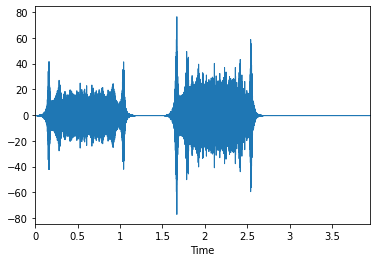

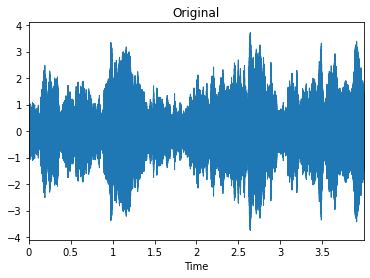

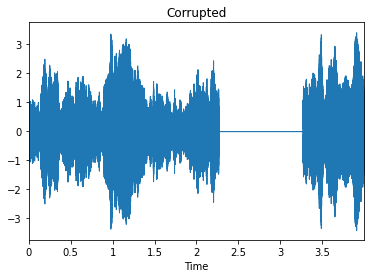

x1mel shape: [ 2 26 36 34 27 27]
x2mel shape: [18 42 52 50 43 43]


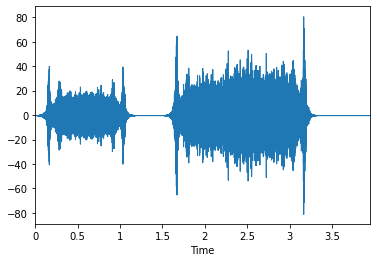

Masked Imgs Mel Shape after min max norm: (64, 128, 64)
11 [D loss: 0.026676, acc: 99.22%] [G loss: 0.939114, mse: 0.940034]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
12 [D loss: 0.013278, acc: 100.00%] [G loss: 0.944783, mse: 0.945704]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
13 [D loss: 0.025363, acc: 100.00%] [G loss: 0.935474, mse: 0.936409]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
14 [D loss: 0.359123, acc: 50.78%] [G loss: 163752.828125, mse: 163916.750000]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
15 [D loss: 0.008802, acc: 100.00%] [G loss: 0.940330, mse: 0.940904]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
16 [D loss: 0.008171, acc: 100.00%] [G loss: 0.941852, mse: 0.942476]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
17 [D loss: 0.027565, acc: 98.44%] [G loss: 0.935888, mse: 0.936482]
Masked Imgs Mel Shape after min max norm: (64, 128, 64)
18 [D loss: 0.028901, acc: 99.22%] [G loss: 0.926219, m

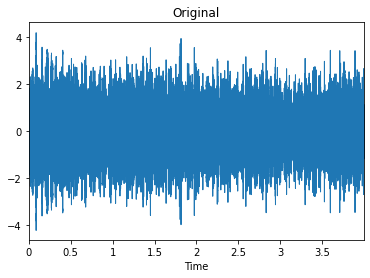

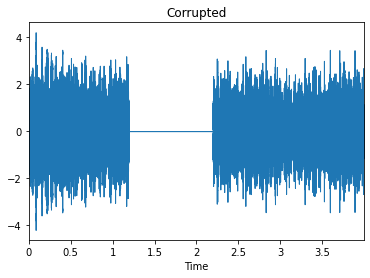

x1mel shape: [19  8 22 47  9  8]
x2mel shape: [35 24 38 63 25 24]


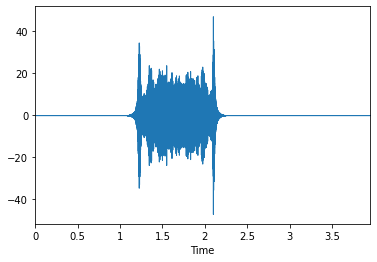

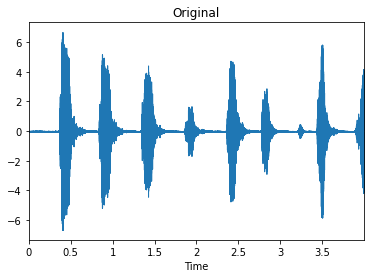

KeyboardInterrupt: ignored

In [7]:
from __future__ import print_function, division
import matplotlib.pyplot as plt
import numpy as np

class ContextEncoder():
    def __init__(self):
        # immagini di 128x63 (melspectrogram) e corruzione di 128x16 (corrispondente ad una corruzione di 8000 sulla waveform); numero di canali: 1 
        self.img_rows = 128
        self.img_cols = 64 #65 con hop length=500, 63 con hop length=512
        self.mask_height = 128
        # 16=8000; 8=4000; 4=2000; 2=1000; 1=500 etc..
        self.mask_width = 16
        self.channels = 1
        self.num_classes = 2 # not used
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.missing_shape = (self.mask_height, self.mask_width, self.channels)
        self.sr=8000 # sampling rate

        optimizer = Adam(0.0001, 0.5)

        # Build and compile the discriminator
        self.discriminator = self.build_discriminator()
        self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

        # Build the generator
        self.generator = self.build_generator()

        # The generator takes noise as input and generates the missing
        # part of the image
        masked_img = Input(shape=self.img_shape)
        gen_missing = self.generator(masked_img)
        print(gen_missing.shape)
        # For the combined model we will only train the generator
        self.discriminator.trainable = False

        # The discriminator takes generated images as input and determines
        # if it is generated or if it is a real image
        valid = self.discriminator(gen_missing)

        # The combined model  (stacked generator and discriminator)
        # Trains generator to fool discriminator
        self.combined = Model(masked_img , [gen_missing, valid])
        self.combined.compile(loss=['mse', 'binary_crossentropy'],
            loss_weights=[0.999, 0.001],
            optimizer=optimizer)
        
        from sklearn.preprocessing import MinMaxScaler
        self.mms = MinMaxScaler(feature_range=(-1,1))
        from sklearn.preprocessing import MaxAbsScaler
        self.mas = MaxAbsScaler()

    def build_generator(self):

        model = Sequential()

        # Encoder
        model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=self.img_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Conv2D(512, kernel_size=1, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.5))

        # Decoder
        model.add(UpSampling2D(size=(4,2))) # it doubles the dimensions of the input
        model.add(Conv2D(128, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(UpSampling2D(size=(4,2)))
        model.add(Conv2D(64, kernel_size=3, padding="same"))
        model.add(Activation('relu'))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(self.channels, kernel_size=3, padding="same"))
        model.add(Activation('tanh'))

        # Useful for normalization
        model.add(Conv2D(self.channels, kernel_size=1, padding="same"))

        model.summary()

        print("PRINT IMG SHAPE", self.img_shape)
        masked_img = Input(shape=self.img_shape) #immagine a cui manca un pezzo
        gen_missing = model(masked_img) # pezzo ricostruito 

        return Model(masked_img, gen_missing)

    def build_discriminator(self):

        model = Sequential()

        model.add(Conv2D(64, kernel_size=3, strides=2, input_shape=self.missing_shape, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Conv2D(256, kernel_size=3, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        model.add(Flatten())
        model.add(Dense(1, activation='sigmoid'))
        model.summary()

        img = Input(shape=self.missing_shape) # pezzo mancante ricostruito 
        validity = model(img)

        return Model(img, validity)

    def mask_randomly(self, imgs_original):
        imgs = copy.deepcopy(imgs_original)
        
        # corrompo la waveform 
        corruption_length=8000
        masked_imgs = []
        missing_parts = np.empty((imgs.shape[0], corruption_length, self.channels))
        masked_imgs_mel = []
        missing_parts_mel = []
        x1 = []
        x2 = []
        x1_mel = []
        x2_mel = [] 
        for i, sample in enumerate(imgs):
          rand1 = random.randint(0, int(len(sample)/1.3)) #24000 
          zeros = np.zeros(shape=sample[rand1:].shape)
          if (sample[rand1:]==zeros).all() == True or sample[rand1:rand1+corruption_length, :].shape[0]<8000:
              rand1 = random.randint(0, int(len(sample)/6)) # 5000 
              missing_parts[i]=sample[rand1:rand1+corruption_length, :]
          else:
              missing_parts[i]=sample[rand1:rand1+corruption_length, :]
          sample[rand1:rand1+corruption_length] = 0 
          masked_imgs.append(sample)
          # converto la waveform in mel spectrogram
          masked_imgs_mel.append(librosa.feature.melspectrogram(y=sample.reshape(-1), sr=self.sr, hop_length=501)) # hop length = 500 ? 
          '''
          self.batch_min = np.min(masked_imgs_mel[i])
          self.batch_max = np.max(masked_imgs_mel[i])
          masked_imgs_mel[i] = (masked_imgs_mel[i] - self.batch_min) / (self.batch_max -self.batch_min)
          '''
          # converto il frammento corrotto in mel spectrogram
          missing_parts_mel.append(librosa.feature.melspectrogram(y=missing_parts[i].reshape(-1), sr=self.sr, hop_length=501))
          x1.append(rand1)
          x2.append(rand1+corruption_length)
          x1_mel.append(round(rand1/500))
          x2_mel.append(round((rand1+corruption_length)/500))
        
        missing_parts_mel = np.array(missing_parts_mel) # (64, 128, 16)
        masked_imgs_mel = np.array(masked_imgs_mel) # (64, 128, 63)
        self.batch_min = np.min(masked_imgs_mel, axis=(1,2)) # (64,)
        self.batch_max = np.max(masked_imgs_mel, axis=(1,2)) # (64,)
        self.batch_min = self.batch_min.reshape(-1,1) # (64,1)
        self.batch_max = self.batch_max.reshape(-1,1) # (64,1)
        '''
        self.batch_min_missing = np.min(missing_parts_mel, axis=(1,2)) 
        self.batch_max_missing = np.max(missing_parts_mel, axis=(1,2)) 
        self.batch_min_missing = self.batch_min_missing.reshape(-1,1)
        self.batch_max_missing = self.batch_max_missing.reshape(-1,1)
        '''
        #self.batch_min_tot = np.minimum.reduce([self.batch_min, self.batch_min_missing])
        #self.batch_max_tot = np.maximum.reduce([self.batch_max, self.batch_max_missing])

        zipped_vec = zip(masked_imgs_mel,self.batch_max,self.batch_min)
        #normalized_list = [(x-min_x)/(max_x-min_x) for x,max_x,min_x in zipped_vec]
        normalized_list = [(((x-min_x)/(max_x-min_x))*2) -1 for x,max_x,min_x in zipped_vec]

        normalized_list = np.array(normalized_list)
        masked_imgs_mel = normalized_list
        print("Masked Imgs Mel Shape after min max norm:", masked_imgs_mel.shape)
        #masked_imgs_mel = (masked_imgs_mel - self.batch_min) / (self.batch_max-self.batch_min)
        #missing_parts_mel = (missing_parts_mel - self.batch_min) / (self.batch_max -self.batch_min)   

        zipped_vec_mel = zip(missing_parts_mel,self.batch_max,self.batch_min)
        normalized_list_mel = [(((x-min_x)/(max_x-min_x))*2) -1 for x,max_x,min_x in zipped_vec_mel]

        normalized_list_mel = np.array(normalized_list_mel)
        missing_parts_mel = normalized_list_mel     

        return np.array(masked_imgs), missing_parts, masked_imgs_mel, missing_parts_mel, np.array(x1), np.array(x2), np.array(x1_mel), np.array(x2_mel)

    def train(self, epochs, batch_size=128, sample_interval=50):

        self.X_train = data
        self.data = data
        self.y_train = labels.values

        # Extract classes (at the beginning it was only two classes)
        X0 = self.X_train[(self.y_train == 0).flatten()]
        X1 = self.X_train[(self.y_train == 1).flatten()]
        X2 = self.X_train[(self.y_train == 2).flatten()]
        X3 = self.X_train[(self.y_train == 3).flatten()]
        X4 = self.X_train[(self.y_train == 4).flatten()]
        X5 = self.X_train[(self.y_train == 5).flatten()]
        X6 = self.X_train[(self.y_train == 6).flatten()]
        X7 = self.X_train[(self.y_train == 7).flatten()]
        X8 = self.X_train[(self.y_train == 8).flatten()]
        X9 = self.X_train[(self.y_train == 9).flatten()]

        # Stack arrays in sequence vertically (row wise)
        self.X_train = np.vstack((X0, X1, X2, X3, X4, X5, X6, X7, X8, X9))

        '''
        for i in self.X_train:
          self.rms = np.sqrt(np.mean(i**2))
          i = i.reshape(-1)/self.rms  
        '''      
        # Rescale -1 to 1
        # X_train.shape = (8732, 32000, 1)
        # self.X_train = self.mms.fit_transform(self.X_train.reshape(self.X_train.shape[0], 32000)) # (8732,32000)
        self.X_train = self.X_train.reshape(self.X_train.shape[0], 32000, 1)
        # X_train.shape = (8732, 32000, 1)
        #y_train = y_train.reshape(-1, 1)
        # Adversarial ground truths
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):
          # ---------------------
          #  Train Discriminator
          # ---------------------

          # Select a random batch of images
          idx = np.random.randint(0, self.X_train.shape[0], batch_size)
          imgs = self.X_train[idx]

          # both referred to mel
          _, _, masked_imgs, missing_parts, _, _, _, _= self.mask_randomly(imgs)
         
          # masked_imgs.shape = (64, 128, 63) dimensione mel spectrogram associato a waveform 32000,1 (batch_size, row, cols)
          # missing_parts.shape = (64, 128, 16) dimensione mel spetrogram associato a frammento corroto 8000,1 (batch_size, row, cols)          

          # Generate a batch of new images
          gen_missing = self.generator.predict(masked_imgs)
          original_shape = gen_missing.shape
          # gen_missing = self.mas.fit_transform(gen_missing.reshape(gen_missing.shape[0], -1)).reshape(original_shape)
          #librosa.display.waveplot(librosa.feature.inverse.mel_to_audio(missing_parts[1]))
          #plt.title("Corrupted part fed to the net ")
          #plt.show()

          # Train the discriminator          
          d_loss_real = self.discriminator.train_on_batch(missing_parts, valid)
          d_loss_fake = self.discriminator.train_on_batch(gen_missing, fake)
          d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

          # ---------------------
          #  Train Generator
          # ---------------------

          g_loss = self.combined.train_on_batch(masked_imgs, [missing_parts, valid])

          # Plot the progress
          print ("%d [D loss: %f, acc: %.2f%%] [G loss: %f, mse: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss[0], g_loss[1]))
          
          # If at save interval => save generated image samples
          if epoch % sample_interval == 0:
              idx = np.random.randint(0, self.X_train.shape[0], 6)
              imgs = self.X_train[idx]
              self.sample_images(epoch, imgs)
          gc.collect() 
    
    # bozza per salvare dataset ricostruito
    def save_images(self, imgs, path):
       reconstructed_audio = []
       from tqdm import tqdm # progress bar
       masked_imgs, missing_parts, masked_imgs_mel, missing_parts_mel, x1, x2 = self.mask_randomly(imgs)
       gen_missing = self.generator.predict(masked_imgs_mel)
       '''
       original_shape = gen_missing.shape
       gen_missing = self.mas.fit_transform(gen_missing.reshape(gen_missing.shape[0], -1)).reshape(original_shape)
       '''
       print("Shape gen missing: ",gen_missing[:].shape) # (8732, 128, 16, 1)
       cnt = 0 #contatore
       for i in tqdm(range(int(imgs.shape[0]/100))): # 8732
         try:
          tmp = gen_missing[i].reshape(128,16) # tmp.dtype = float32 
          mel_to_wave_missing = librosa.feature.inverse.mel_to_audio(tmp, sr=self.sr)
          # mel to wave missing shape: (7680,)
          # mel_to_wave_missing = self.mas.fit_transform(mel_to_wave_missing.reshape(-1, 1))
          zeros = np.zeros((8000,1)) 
          zeros[:mel_to_wave_missing.shape[0], :] = mel_to_wave_missing
          recon_wave = copy.deepcopy(masked_imgs[i, :, :])
          recon_wave[x1[i]:x2[i], :] = zeros
          reconstructed_audio.append(recon_wave)
         except ParameterError:
           cnt+=1
           continue   
       savez_compressed(path, reconstructed_audio)

    def sample_images(self, epoch, imgs):
        r, c = 3, 6        

        masked_imgs, missing_parts, masked_imgs_mel, missing_parts_mel, x1, x2, x1_mel, x2_mel = self.mask_randomly(imgs) #x1.shape = (#images, 1)
       
        # parte ricostruita del mel spectrogram (quello che era 8x8)
        gen_missing = self.generator.predict(masked_imgs_mel) #dtype = float32   
        
        # normalizzare il valore gen_missing dividendo per il massimo del valore assoluto 
        print("GEN MISSING SHAPE: ", gen_missing.shape)

        '''
        imgs = 0.5 * imgs + 0.5
        masked_imgs = 0.5 * masked_imgs + 0.5
        gen_missing = 0.5 * gen_missing + 0.5
        '''
        for i in range(3):
          #waveform originale      
          librosa.display.waveplot(imgs[i, :, :].reshape(-1), sr=8000)
          plt.title("Original")
          plt.show()

          #waveform corrotta
          librosa.display.waveplot(masked_imgs[i, :, :].reshape(-1), sr=8000)
          plt.title("Corrupted")
          plt.show()

          tmp = gen_missing[i].reshape(128,16) # from (128,16,1) to (128,16)
          tmp = ((tmp+1)/2 * (self.batch_max[i]-self.batch_min[i])) +  self.batch_min[i]
          
          print("x1mel shape:", x1_mel)
          print("x2mel shape:", x2_mel)
          masked_imgs_mel[:,:,x1_mel[i]:x2_mel[i]] = tmp 
          #plot_spectrogram(masked_imgs_mel[i,:,:])
          reconstructed_waves = librosa.feature.inverse.mel_to_audio(masked_imgs_mel[i,:,:], sr=self.sr, hop_length=501)
          librosa.display.waveplot(reconstructed_waves.reshape(-1), sr=self.sr)
          plt.show()
          '''
          #plot_spectrogram(tmp) 
          mel_to_wave_missing = librosa.feature.inverse.mel_to_audio(tmp, sr=self.sr, hop_length=500)
          #print("RMS:", self.rms)
          mel_to_wave_missing = mel_to_wave_missing #*self.rms
          mel_to_wave_missing = mel_to_wave_missing.reshape(-1, 1) # aggiunto dopo aver commentato il maxabsscaler 
          # mel_to_wave_missing = self.mas.fit_transform(mel_to_wave_missing.reshape(-1, 1)) 
          #print("Recon wave shape, expected (circa 8000): ", mel_to_wave_missing.shape) # (circa 8000,1)
          zeros = np.zeros((8000,1)) 
          zeros[:mel_to_wave_missing.shape[0], :] = mel_to_wave_missing    
          # mel to wave con padding per colmare gli 8000     
          #print("Corrupted fragment shape wave, expected (8000, ):", zeros.shape) # (8000,)
          recon_wave = copy.deepcopy(masked_imgs[i, :, :])
          recon_wave[x1[i]:x2[i], :] = zeros 
          #print("Recon wave shape, expected (32000,1)", recon_wave.shape)
          # wave ricostruita (32000, 1)
          librosa.display.waveplot(recon_wave.reshape(-1), sr=self.sr)
          plt.title("Reconstrucred waveform")
          plt.show()
          #reconstructed = masked_imgs[i, :, :]
          print("")
          print("*"*50)
          '''
        gc.collect() 

    def save_model(self):
        def save(model, model_name):
            model_path = "saved_model/%s.json" % model_name
            weights_path = "saved_model/%s_weights.hdf5" % model_name
            options = {"file_arch": model_path,
                        "file_weight": weights_path}
            json_string = model.to_json()
            open(options['file_arch'], 'w').write(json_string)
            model.save_weights(options['file_weight'])

        save(self.generator, "generator")
        save(self.discriminator, "discriminator")

if __name__ == '__main__':
    context_encoder = ContextEncoder()
    context_encoder.train(epochs=50, batch_size=64, sample_interval=10)
    #context_encoder.save_images(context_encoder.X_train, "/content/gdrive/MyDrive/UrbanSound8K/dati/reconstructed_8kHz.npz")